In [233]:
%load_ext autoreload
%autoreload 2
import sys
import pickle
from pathlib import Path
gpu_implementation_path = '/home/mt/repos/research.mtne/gpu_implementation'
if gpu_implementation_path not in sys.path:
    sys.path.append(gpu_implementation_path)
gpu_implementation_analysis_path = '/home/mt/repos/research.mtne/gpu_implementation/analysis'
if gpu_implementation_analysis_path not in sys.path:
    sys.path.append(gpu_implementation_analysis_path)
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import utils
from metrics import *

# from esmt import TrainingState

main_log_dir = Path(gpu_implementation_path) / "logs"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
experiments = {
    'ST-zaxxon': {'dir': main_log_dir / 'ST-zaxxon-5000', 'type': 'ST'},
    'ST-riverraid': {'dir': main_log_dir / 'ST-riverraid-5000', 'type': 'ST'},
    'MT': {'dir': main_log_dir / 'MT-zaxxon-riverraid-5000', 'type': 'MT' },
    'ST-riverraid-zaxxon': {'dir': main_log_dir / 'evaluate_riverraid_using_zaxxon_model', 'type': 'ST'},
    'ST-zaxxon-riverraid': {'dir': main_log_dir / 'evaluate_zaxxon_using_riverraid_model', 'type': 'ST'}    
}

In [235]:
for exp_name, exp in experiments.items():
    exp['cfg'] = utils.get_config(exp)
    exp['rewards'] = utils.get_rewards(exp)
e = experiments

/home/mt/repos/research.mtne/gpu_implementation/logs/evaluate_riverraid_using_zaxxon_model


/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


/home/mt/repos/research.mtne/gpu_implementation/logs/evaluate_zaxxon_using_riverraid_model
/home/mt/repos/research.mtne/gpu_implementation/logs/MT-zaxxon-riverraid-5000
/home/mt/repos/research.mtne/gpu_implementation/logs/ST-zaxxon-5000
/home/mt/repos/research.mtne/gpu_implementation/logs/ST-riverraid-5000


In [236]:
e['MT']['cfg']

{'episode_cutoff_mode': 5000,
 'games': ['zaxxon', 'riverraid'],
 'iterations': 329,
 'l2coeff': 0.005,
 'learn_option': 'concat_rewards',
 'learn_options': ['concat_rewards',
  'alternate_games',
  'equal_prob_random_choice'],
 'model': 'ModelVirtualBN',
 'mutation_power': 0.02,
 'num_test_episodes': 400,
 'num_validation_episodes': 30,
 'optimizer': {'args': {'stepsize': 0.01}, 'type': 'adam'},
 'population_size': 10000,
 'population_size_comment': 'Must be divisible by 4',
 'return_proc_mode': 'centered_rank',
 'timesteps': 5000000000.0}

In [237]:
iterations = 200

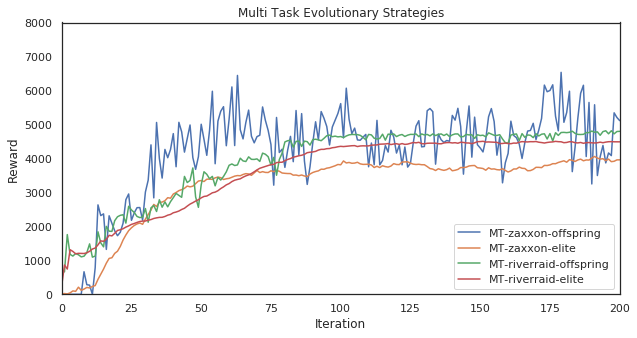

In [238]:
# 1) MTES rewards (both offspring and elite)
# x axis: iterations (0 to 200)
# y axis: rewards
# lines: (a) riverraid, offspring; (b) riverraid, elite; (c) zaxxon, offspring; (d) zaxxon, elite.
df = e['MT']['rewards'].copy()
df.columns = ['MT-zaxxon-offspring', 'MT-zaxxon-elite', 'MT-riverraid-offspring', 'MT-riverraid-elite']
# df['Iteration'] = df.index
# melted = pd.melt(df, id_vars=['Iteration'])

### BLACK AND WHITE PLOT
# sns.set(rc={'figure.figsize': (10, 5)})
# sns.set_style('white')
# p = sns.lineplot(x='Iteration', y='value', style='variable', color='black', data=melted)
# p.set_title('Multi Task Evolutionary Strategies; TODO: explain rewards and elite')
# p.set_ylabel('Reward')
# p.set(xlim=(0, iterations))
# p.get_figure().savefig("plot1.eps")

### presentation plot
sns.set(rc={'figure.figsize': (10, 5)})
sns.set_style('white')
p = df.plot()
# p = sns.lineplot(x='Iteration', y='value', hue='variable', data=melted)
p.set_title('Multi Task Evolutionary Strategies')
p.set_ylabel('Reward')
p.set_xlabel('Iteration')
p.set(ylim=(0, 8000))
p.set(xlim=(0, iterations))
p.get_figure().savefig("figures/plot1.eps")

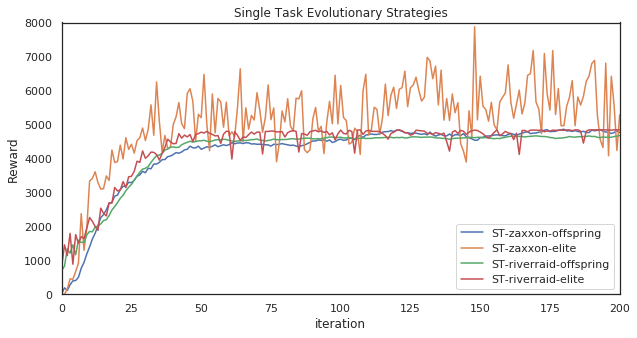

In [239]:
# 1.1) MTES rewards (both offspring and elite)
# x axis: iterations (0 to 200)
# y axis: rewards
# lines: (a) riverraid, offspring; (b) riverraid, elite; (c) zaxxon, offspring; (d) zaxxon, elite.
df_zaxxon = e['ST-zaxxon']['rewards'].copy()
df_zaxxon.columns = ['ST-zaxxon-offspring', 'ST-zaxxon-elite']
df_riverraid = e['ST-riverraid']['rewards'].copy()
df_riverraid.columns = ['ST-riverraid-offspring', 'ST-riverraid-elite']
df = df_zaxxon.join(df_riverraid)
# melted = pd.melt(df, id_vars=['Iteration'])

# ### BLACK AND WHITE PLOT
# # sns.set(rc={'figure.figsize': (10, 5)})
# # sns.set_style('white')
# # p = sns.lineplot(x='Iteration', y='value', style='variable', color='black', data=melted)
# # p.set_title('Multi Task Evolutionary Strategies; TODO: explain rewards and elite')
# # p.set_ylabel('Reward')
# # p.set(xlim=(0, iterations))
# # p.get_figure().savefig("plot1.eps")

# ### presentation plot
# sns.set(rc={'figure.figsize': (10, 5)})
# sns.set_style('white')
p = df.plot()
p.set_title('Single Task Evolutionary Strategies')
p.set_ylabel('Reward')
p.set(ylim=(0, 8000))
p.set(xlim=(0, iterations))
p.get_figure().savefig("figures/plot1_1.eps")

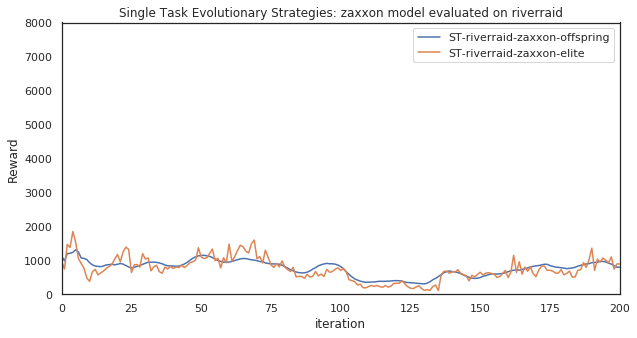

In [240]:
# 1.1) MTES rewards (both offspring and elite)
# x axis: iterations (0 to 200)
# y axis: rewards
# lines: (a) riverraid, offspring; (b) riverraid, elite; (c) zaxxon, offspring; (d) zaxxon, elite.
df = e['ST-riverraid-zaxxon']['rewards'].copy()
df.columns = ['ST-riverraid-zaxxon-offspring', 'ST-riverraid-zaxxon-elite']
# sns.set(rc={'figure.figsize': (10, 5)})
# sns.set_style('white')
p = df.plot()
p.set_title('Single Task Evolutionary Strategies: zaxxon model evaluated on riverraid')
p.set_ylabel('Reward')
p.set(ylim=(0, 8000))
p.set(xlim=(0, iterations))
p.get_figure().savefig("figures/plot2_1.eps")

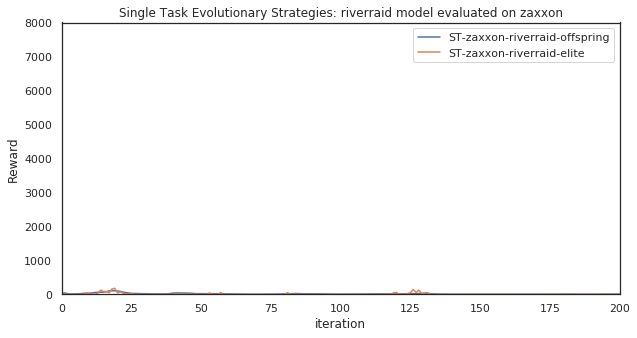

In [241]:
# 1.1) MTES rewards (both offspring and elite)
# x axis: iterations (0 to 200)
# y axis: rewards
# lines: (a) riverraid, offspring; (b) riverraid, elite; (c) zaxxon, offspring; (d) zaxxon, elite.
df = e['ST-zaxxon-riverraid']['rewards'].copy()
df.columns = ['ST-zaxxon-riverraid-offspring', 'ST-zaxxon-riverraid-elite']
# sns.set(rc={'figure.figsize': (10, 5)})
# sns.set_style('white')
p = df.plot()
p.set_title('Single Task Evolutionary Strategies: riverraid model evaluated on zaxxon')
p.set_ylabel('Reward')
p.set(ylim=(0, 8000))
p.set(xlim=(0, iterations))
p.get_figure().savefig("figures/plot2_2.eps")

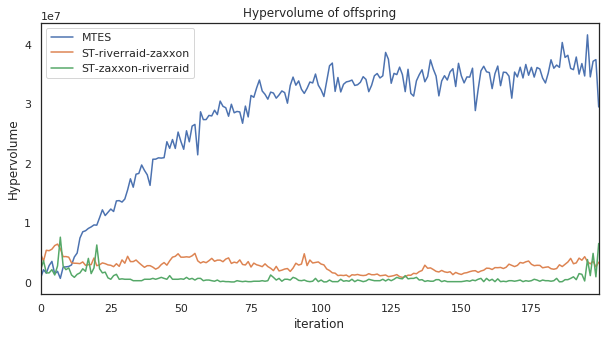

In [242]:
# 4) hypervolume (offspring only)
# x axis: iterations (0 to 200)
# y axis: hypervolume
# lines: (a) MTES
# hv_df = pd.DataFrame.from_dict({
#     'MTES': utils.get_hypervolume_data(experiments['MT'], iterations)['hv'],
#     'ST-zaxxon-riverraid': utils.get_hypervolume_data(experiments['ST-zaxxon-riverraid'], iterations)['hv'],
#     'ST-riverraid-zaxxon': utils.get_hypervolume_data(experiments['ST-riverraid-zaxxon'], iterations)['hv'],
# })
# sns.set(rc={'figure.figsize': (10, 5)})
# hv_df['iteration'] = range(0, iterations)
# hv_df.set_index('iteration')
# del hv_df['iteration']
sns.set_style('white')
p = hv_df.plot()
# p = hv_df.plot(color='black')
p.set_title('Hypervolume of offspring')
p.set_ylabel('Hypervolume')
p.get_figure().savefig("figures/plot4_hypervolume.eps")

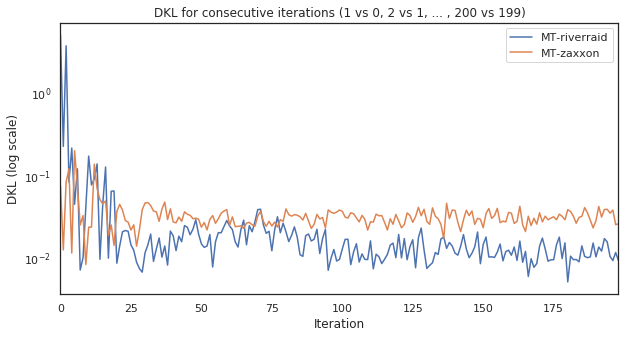

In [243]:
# 5) DKL (offspring only) – 2 plots: one for task 0, one for task 1
# x axis: iterations (0 to 200)
# y axis: DKL for consecutive iterations (1 vs 0, 2 vs 1, 3 vs 2, ... , 200 vs 199)
# lines: (a) MTES; (b) STES [zaxxon evaluated on riverraid]; (c) STES [riverraid evaluated on zaxxon].

bin_size = 100
epsilon = 0.0001
dkl0 = pd.DataFrame.from_dict({
    'MT-zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon) for i in range(1, iterations)],
    'MT-riverraid': [utils.compute_dkl(experiments['MT'], 1, i, bin_size, epsilon) for i in range(1, iterations)]
})

df = dkl0.copy()
# df['iteration'] = df.index
# melted = pd.melt(df, id_vars=['iteration'])
# p = sns.lineplot(x='iteration', y='value', style='variable', color='black', data=melted)
p = df.plot()
p.set_title("DKL for consecutive iterations (1 vs 0, 2 vs 1, ... , 200 vs 199)")
p.set_xlabel("Iteration")
p.set_ylabel("DKL (log scale)")
p.set_yscale('log')
p.get_figure().savefig("figures/plot5_dkl.eps")

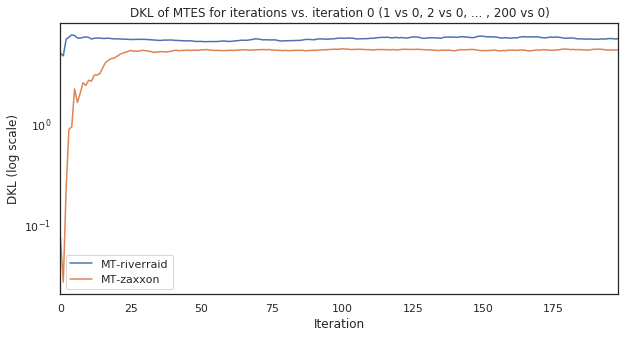

In [244]:
# 6) same as 5), but y axis is “DKL for iterations (1 vs 0, 2 vs 0, 3 vs 0, ... , 200 vs 0)” (note: also in this case we need 2 plots: one for task 0, one for tasak 1)
dkl_from0_0 = pd.DataFrame.from_dict({
    'MTES_zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon, from_0=True) for i in range(1, iterations)],
    'MTES_riverraid': [utils.compute_dkl(experiments['MT'], 1, i, bin_size, epsilon, from_0=True) for i in range(1, iterations)]
})

df = dkl_from0_0.copy()
df.columns = ['MT-riverraid', 'MT-zaxxon']
# df['iteration'] = df.index
# melted = pd.melt(df, id_vars=['iteration'])
# p = sns.lineplot(x='iteration', y='value', style='variable', color='black', data=melted)
p = df.plot()
p.set_title("DKL of MTES for iterations vs. iteration 0 (1 vs 0, 2 vs 0, ... , 200 vs 0)")
p.set_xlabel("Iteration")
p.set_ylabel("DKL (log scale)")
p.set_yscale('log')
p.get_figure().savefig("figures/plot6_dkl_mtes.eps")

In [245]:
### SCATTERPLOTS

In [246]:
iterlist = [0, 25, 50, 75, 100, 125, 150, 175, 199]

def get_paretos(exp, iterations, rewards=None, iterlist=iterlist):
    game_rewards = utils.get_game_rewards(exp, iterations) if rewards is None else rewards
    paretos = []
    for iteration in range(0, iterations):
        game0_rewards = game_rewards[game_rewards.iteration == iteration]['game0_rewards']
        game1_rewards = game_rewards[game_rewards.iteration == iteration]['game1_rewards']
        pareto_x, pareto_y = utils.compute_pareto(game0_rewards, game1_rewards)
        paretos.append(pd.DataFrame({'iteration': [iteration] * len(pareto_x), 'game0_rewards': pareto_x, 'game1_rewards': pareto_y}))
    paretos_df = pd.concat(paretos)
    only_paretos = paretos_df[paretos_df['iteration'].isin(iterlist)]
    only_paretos['newidx'] = list(range(0, len(only_paretos)))
    only_paretos.set_index('newidx')
    del only_paretos['newidx']
    return only_paretos
def pareto_and_points_for_iteration(game_rewards, paretos, iteration):
    game_rewards_iteration = game_rewards[game_rewards.iteration == iteration]
    paretos_iteration = paretos[paretos.iteration == iteration]
    return game_rewards_iteration, paretos_iteration
def get_scatter_reward_and_pareto(game_rewards, paretos, iteration, plot_title='Experiment', max_x_lim=8000, max_y_lim=8000, xlabel=None, ylabel=None, rewards_colours='grey', paretos_colours='black', swap_games=False):
    game_rewards, paretos = pareto_and_points_for_iteration(game_rewards, paretos, iteration)

    game0_rewards = game_rewards[game_rewards.iteration == iteration]

    xfield = 'game0_rewards'
    yfield = 'game1_rewards'
    if swap_games:
        xfield = 'game1_rewards'
        yfield = 'game0_rewards'
        
    p = sns.scatterplot(x=xfield, y=yfield, color=rewards_colours, alpha=0.05, data=game_rewards)
    p = sns.scatterplot(x=xfield, y=xfield, color=paretos_colours, data=paretos)
    p = sns.lineplot(x=xfield, y=xfield, color=paretos_colours, data=paretos)
    p.set_title(plot_title + " - Iteration {}".format(iteration))
    p.set_xlim([0, max_x_lim])
    p.set_ylim([0, max_y_lim])
    if xlabel is not None:
        p.set_xlabel(xlabel)
    if ylabel is not None:
        p.set_ylabel(ylabel)
    return p
def get_game0vs1_and_pareto_grid(all_game_rewards, only_paretos, iterlist, savefig, xlabel, ylabel):
    iterlist_keys = list(range(1, len(iterlist) + 1))
    iterdict = dict(zip(iterlist_keys, iterlist))
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plot_xlabel = '' if i in [1, 2, 3, 4, 5, 6] else xlabel
        plot_ylabel = '' if i in [2, 3, 5, 6, 8, 9] else ylabel
        get_scatter_reward_and_pareto(all_game_rewards, only_paretos, iterdict[i], xlabel=plot_xlabel, ylabel=plot_ylabel)
    fig.savefig(savefig)
    return fig

In [247]:
game_rewards_mt = utils.get_game_rewards(experiments['MT'], iterations)

In [248]:
paretos_mt = get_paretos(exp, iterations, all_game_rewards)

/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [249]:
experiments['ST-riverraid-zaxxon']['dir_competitor'] = experiments['ST-zaxxon']['dir']
agr_st_riverraid_zaxxon = utils.get_game_rewards(experiments['ST-riverraid-zaxxon'], iterations)
only_paretos_st_riverraid_zaxxon = get_paretos(exp, iterations, agr_st_riverraid_zaxxon)

/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [250]:
experiments['ST-zaxxon-riverraid']['dir_competitor'] = experiments['ST-riverraid']['dir']
agr_st_zaxxon_riverraid = utils.get_game_rewards(experiments['ST-zaxxon-riverraid'], iterations)
only_paretos_st_zaxxon_riverraid = get_paretos(exp, iterations, agr_st_zaxxon_riverraid)

/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


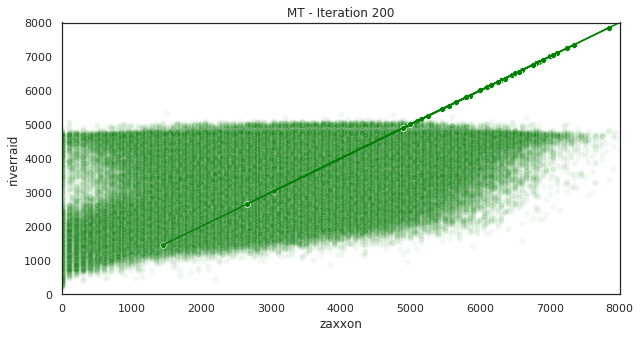

In [253]:
# for i in range(1, 201):
#     p = get_scatter_reward_and_pareto(agr_st_riverraid_zaxxon, only_paretos_st_riverraid_zaxxon, i, plot_title='ST-zaxxon-riverraid', rewards_colours='blue', paretos_colours='blue', xlabel='zaxxon using riverraid', ylabel='riverraid')
#     p.get_figure().savefig('figures/plot_pareto_st_riverraid_zaxxon-{}.png'.format(i))
#     del p

# for i in range(1, 201):
#     p2 = get_scatter_reward_and_pareto(agr_st_zaxxon_riverraid, only_paretos_st_zaxxon_riverraid, i, plot_title='ST-riverraid-zaxxon', rewards_colours='red', paretos_colours='red', xlabel='zaxxon', ylabel='riverraid using zaxxon model', swap_games=True)
#     p2.get_figure().savefig('figures/plot_pareto_st_zaxxon_riverraid-{}.png'.format(i))
#     del p2

for i in range(1, 201):
    p3 = get_scatter_reward_and_pareto(game_rewards_mt, paretos_mt, i, plot_title='MT', rewards_colours='green', paretos_colours='green', xlabel='zaxxon', ylabel='riverraid')
    p3.get_figure().savefig('figures/plot_pareto_mt-{}.png'.format(i))
    del p3

In [170]:
iterlist

[0, 25, 50, 75, 100, 125, 150, 175, 199]

In [ ]:
get_game0vs1_and_pareto_grid(all_game_rewards, only_paretos, iterlist, savefig='scatterplot1.eps', xlabel='zaxxon', ylabel='riverraid')

/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


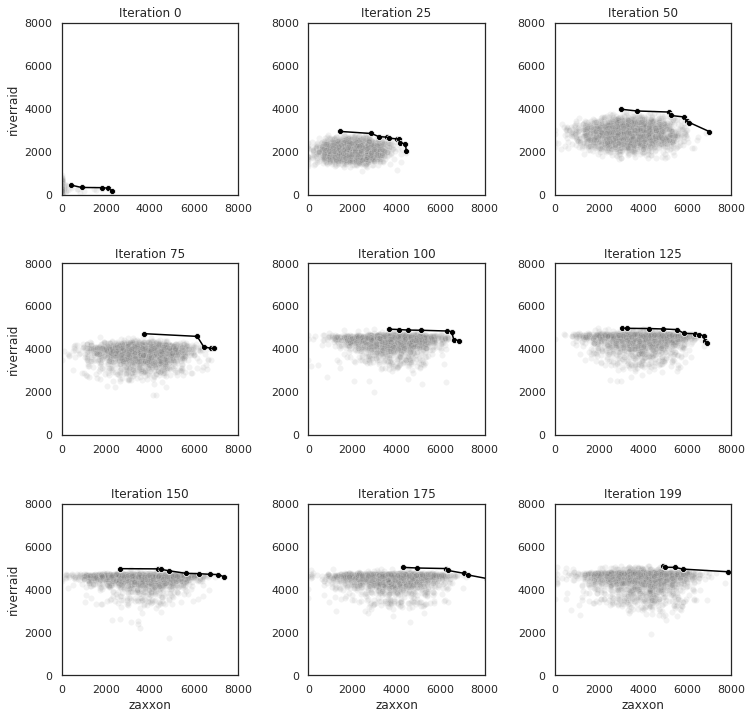

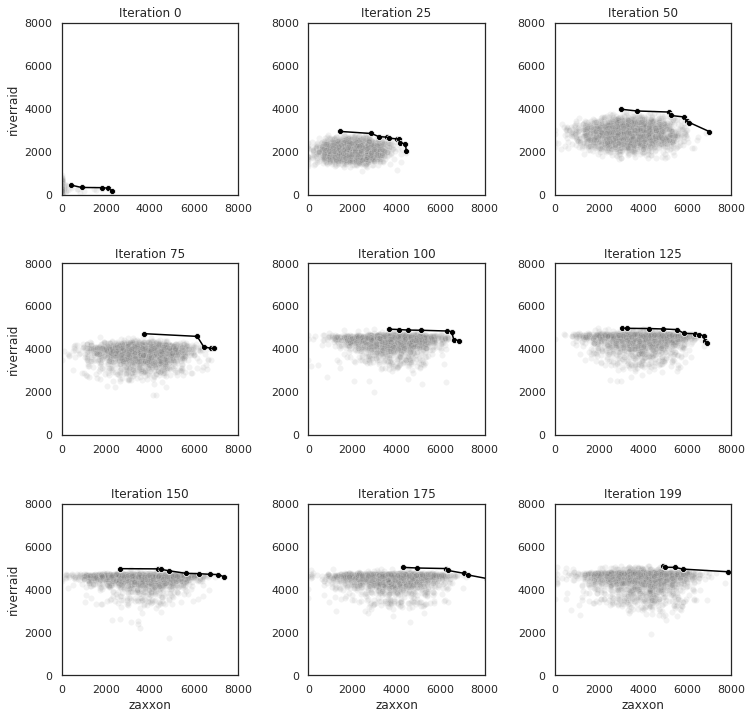

In [162]:
# Scatterplots: (one plot for iterations: [0, 25, 50, 75, 100, 125, 150, 175, 200] ) → 9 plots
# 1) MTES (only offspring)
# x axis: Game 0
# y axis: Game 1
# points: (a) feasible points only (reward>0); (b) pareto front points, in red + red line connecting those points.
all_game_rewards = utils.get_game_rewards(experiments['MT'], iterations)
only_paretos = get_paretos(exp, iterations, all_game_rewards)
get_game0vs1_and_pareto_grid(all_game_rewards, only_paretos, iterlist, savefig='scatterplot1.eps', xlabel='zaxxon', ylabel='riverraid')

/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


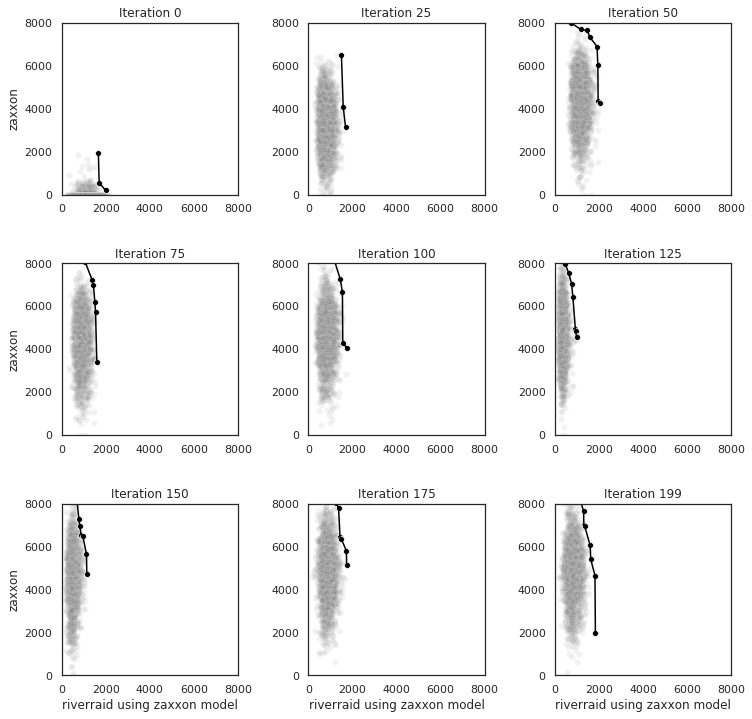

In [95]:
# 2) same as (1), but STES [zaxxon evaluated on riverraid] instead of MTES
# here game0 is "riverraid evaluated using zaxxon model" and game1 is ST zaxxon (competitor)
experiments['ST-riverraid-zaxxon']['dir_competitor'] = experiments['ST-zaxxon']['dir']
agr_st_riverraid_zaxxon = utils.get_game_rewards(experiments['ST-riverraid-zaxxon'], iterations)
only_paretos_st_riverraid_zaxxon = get_paretos(exp, iterations, agr_st_riverraid_zaxxon)
p = get_game0vs1_and_pareto_grid(agr_st_riverraid_zaxxon, only_paretos_st_riverraid_zaxxon, iterlist, savefig='scatterplot2.eps', xlabel='riverraid using zaxxon model', ylabel='zaxxon')

/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


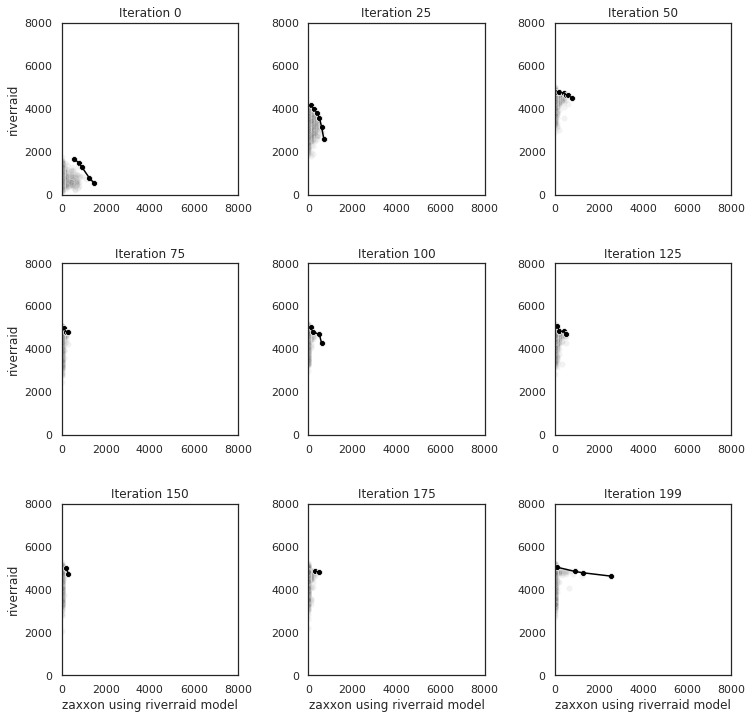

In [96]:
# 3) same as (2) but STES [riverraid evaluated on zaxxon]
# here game0 is "zaxxon evaluated using riverraid model" and game1 is ST riverraid (competitor)
experiments['ST-zaxxon-riverraid']['dir_competitor'] = experiments['ST-riverraid']['dir']
agr_st_zaxxon_riverraid = utils.get_game_rewards(experiments['ST-zaxxon-riverraid'], iterations)
only_paretos_st_zaxxon_riverraid = get_paretos(exp, iterations, agr_st_zaxxon_riverraid)
p = get_game0vs1_and_pareto_grid(agr_st_zaxxon_riverraid, only_paretos_st_zaxxon_riverraid, iterlist, savefig='scatterplot3.eps', xlabel='zaxxon using riverraid model', ylabel='riverraid')

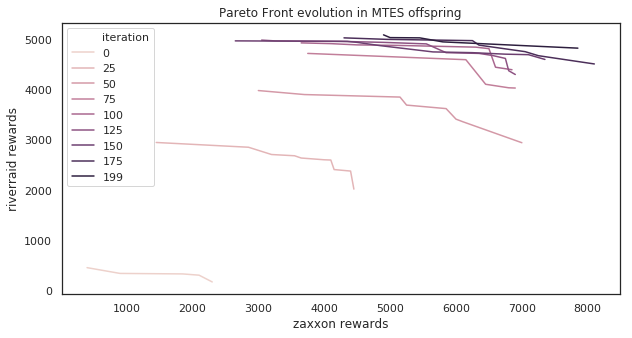

In [97]:
# 1) MTES (only offspring)
# x axis: Game 0
# y axis: Game 1
# points: pareto front points + line connecting those points. One line for each iterations in [0, 25, 50, 75, 100, 125, 150, 175, 200]
p = sns.lineplot(x='game0_rewards', y='game1_rewards', hue='iteration', color='black', legend='full', data=only_paretos)
p.set_title("Pareto Front evolution in MTES offspring")
p.set_xlabel('zaxxon rewards')
p.set_ylabel('riverraid rewards')
p.get_figure().savefig("paretofront.eps")